## 0) Utilities

In [1]:
## General librairies
import pandas as pd
import numpy as np
import _pickle as pickle
import matplotlib.pyplot as plt
import random
import sys
import time
from copy import deepcopy


## Cosine Distance
from scipy.spatial.distance import cosine


## Keras utilities
import keras
import tensorflow
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import keras.backend as K
from keras.layers import Input, Conv2D, Lambda,  Dense,Concatenate, Flatten,MaxPooling2D,Dropout, UpSampling2D,GlobalMaxPooling2D, GlobalAveragePooling2D
# from tensorflow.keras.engine.input_layer import Input
from keras.layers import merge
from keras.optimizers import SGD,Adam
from keras.regularizers import l2
from keras.layers import Input, Dense, UpSampling2D,Cropping2D, ZeroPadding2D,RepeatVector, Reshape, Conv2DTranspose, BatchNormalization
import numpy.random as rng
from sklearn.utils import shuffle
from keras.layers.advanced_activations import LeakyReLU
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

## Sklearn utilities
#### Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
#### Scores
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#### Feature transformations
import umap




## Removing some of the useless warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Using TensorFlow backend.


In [2]:
## Some useful functions to ease the processings
def save(file,name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'wb')
    else:
        outfile = open(name+'.pickle', 'wb')
    pickle.dump(file, outfile)
    outfile.close
    
def load(name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'rb')
    else:
        outfile = open(name+'.pickle', 'rb')
    file = pickle.load(outfile)
    outfile.close
    return file

def plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    x = list(range(len(acc)))
    plt.plot(x,acc)
    plt.plot(x,val_acc)
    
def cat_to_num(y):
    y1 = []
    for i in range(y.shape[0]):
        a = 0
        for j in range(y.shape[1]):
            a += j*y[i,j]
        y1.append(int(a))
    return y1

def generate_integer():
    
    ints = []
    
    while len(ints)<5:
        r = random.randint(0,63)
        if not(r in ints):
            ints.append(r)
    return ints

## 1) Meta Training

#### Neural Net Architecture

#### Loading and plotting the meta-learning set

<Figure size 432x288 with 0 Axes>

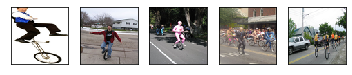

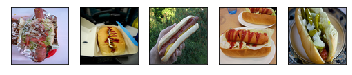

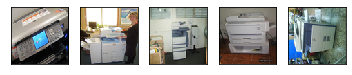

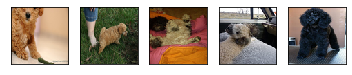

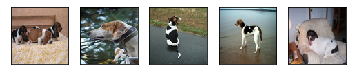

In [3]:
OT = pickle.load(open('miniImageNet_category_split_train_phase_train.pickle', 'rb'), encoding='latin1')

for i in range(5):
    plt.figure(i)
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)
    for j in range(5):
        fig.axes[j].get_xaxis().set_visible(False)
        fig.axes[j].get_yaxis().set_visible(False)
    ax1.imshow(OT['data'][600*i+1])
    ax2.imshow(OT['data'][600*i+2])    
    ax3.imshow(OT['data'][600*i+3])
    ax4.imshow(OT['data'][600*i+4])
    ax5.imshow(OT['data'][600*i+5])
    
Y_meta = OT['labels']
X_meta = OT['data']

y_meta = np_utils.to_categorical(Y_meta)
del OT

#### Setting up the training of the neural net on the meta learning set

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_meta, y_meta, test_size=0.2, random_state=42)

###### First training of the model

In [5]:
X_train = X_train / 255
X_test = X_test / 255

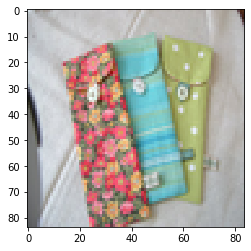

In [6]:
plt.imshow(X_train[0])

In [7]:
def autoencoder(img_shape, gf):
        def conv2d(layer_input, filters, f_size=4, padding = 'same'):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding=padding)(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0, crop = False):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            if crop:
                u= Cropping2D(cropping=((0, 1), (0, 1)))(u)
#             u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=img_shape)

        # Downsampling
        d1 = conv2d(d0, gf)
        d2 = conv2d(d1, gf*2)
        d3 = conv2d(d2, gf*4)
        d4 = conv2d(d3, gf*8)

        # Upsampling
        
#         d4 = Cropping2D(cropping=((0, 1), (0, 1)))(d4)
        
        u1 = deconv2d(d4, d3, gf*4, crop = True)
        u2 = deconv2d(d3, d2, gf*2, crop = True)
        u3 = deconv2d(u2, d1, gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)
        
        model = Model(d0, output_img)
        return model

In [8]:
ae = autoencoder((84,84,3), 32)

In [9]:
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 84, 84, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 32)        1568      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 42, 42, 32)        0         
_________________________________________________________________
instance_normalization_1 (In (None, 42, 42, 32)        2         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        32832     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 21, 21, 64)        0         
_________________________________________________________________
instance_normalization_2 (In (None, 21, 21, 64)        2         
__________

In [17]:
optimizer=keras.optimizers.RMSprop(0.0001)
ae.compile(loss='mse',
              optimizer=optimizer,#keras.optimizers.Adadelta(),
                )

In [18]:
batch_size = 64
epochs = 10

history = ae.fit(X_train, X_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test, X_test))

Train on 30720 samples, validate on 7680 samples
Epoch 1/10
30720/30720 [==============================] - 35s 1ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 2/10
30720/30720 [==============================] - 35s 1ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 3/10
30720/30720 [==============================] - 35s 1ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 4/10
30720/30720 [==============================] - 35s 1ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 5/10
  704/30720 [..............................] - ETA: 30s - loss: 0.0035

KeyboardInterrupt: 

In [36]:
save(ae, 'autoencoder vgg', 'model')

In [26]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

model_transfert = VGG16(weights=None, include_top=False, input_shape = (84,84,3))


In [28]:
model_transfert.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 84, 84, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 84, 84, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 84, 84, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 42, 42, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 42, 42, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 42, 42, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 21, 21, 128)       0         
__________

In [29]:
# model_transfert = load('3.resnet18 with augmentation step 0.001', 'model') #average_pooling2d_3 activation_51
# batch_normalization_35 max_pooling2d_3
inputs = model_transfert.input
# outputs = model_transfert.get_layer('average_pooling2d_3').output
outputs = model_transfert.outputs
outputs = Flatten()(outputs)
disc = Model(inputs=inputs,   outputs=outputs)

for layer in disc.layers:
    layer.trainable = False


# ae = autoencoder((84,84,3), 32)

input1 = Input(shape=(84,84,3))

img_feats = disc(input1)

img_rec = ae(input1)
img_rec_feats = disc(img_rec)

merge_layer = Lambda(lambda  x : K.abs(x[0]-x[1]), output_shape = lambda x : x[0])
both = merge_layer([img_feats,img_rec_feats])

model = Model(input1, both)

In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 84, 84, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 84, 84, 3)    331085      input_3[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 2048)         14714688    input_3[0][0]                    
                                                                 model_1[1][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2048)         0           model_2[1][0]                    
          

In [31]:
y_train = np.zeros((X_train.shape[0], 2048))
y_test = np.zeros((X_test.shape[0], 2048))

In [34]:
optimizer=SGD(0.01)
model.compile(loss='mse',
              optimizer=optimizer,#keras.optimizers.Adadelta(),
                )

In [35]:
batch_size = 64
epochs = 10

history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test, y_test))

Train on 30720 samples, validate on 7680 samples
Epoch 1/10
30720/30720 [==============================] - 97s 3ms/step - loss: 1.8734e-08 - val_loss: 1.8752e-08
Epoch 2/10
30720/30720 [==============================] - 89s 3ms/step - loss: 1.8730e-08 - val_loss: 1.8749e-08
Epoch 3/10
30720/30720 [==============================] - 89s 3ms/step - loss: 1.8727e-08 - val_loss: 1.8745e-08
Epoch 4/10
 4864/30720 [===>..........................] - ETA: 1:08 - loss: 1.8701e-08

KeyboardInterrupt: 

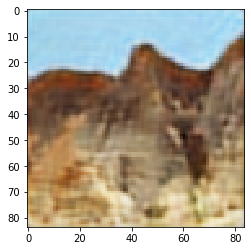

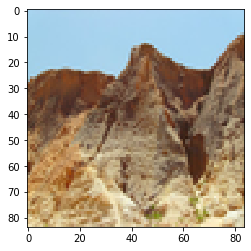

In [48]:
ind = 12000


# model1.predict(np.array([X1[0]])).astype(int).reshape((84,84,3))

plt.figure(0)
plt.imshow(ae.predict(np.array([X_train[ind]])).reshape((84,84,3)))
plt.figure(1)
plt.imshow(X_train[ind])

In [ ]:
save(model, '3.resnet18 with augmentation step 0.001', 'model')

###### Second training of the model

## 2) Experiments

###### Loading and merging the validation data

In [3]:
OT1 = pickle.load(open('miniImageNet_category_split_test.pickle', 'rb'), encoding='latin1')
OT2 = pickle.load(open('miniImageNet_category_split_val.pickle', 'rb'), encoding='latin1')

from copy import deepcopy
Y_val = deepcopy(OT2['labels'])
X_val = deepcopy(OT2['data'])

## Concatenating val and test datas in order to get more classes for experiment
for i in OT1['labels']:
    Y_val.append(i)
X_val = np.concatenate([X_val, OT1['data']], axis = 0)

## Restructuring the images into an array of size 64*600*84*84*3 to ease the acces to a given class
tab = []
for i in range(36):
    tab.append([])

for i in range(len(Y_val)):
    tab[Y_val[i]-64].append(X_val[i])

X = np.array(tab)

In [4]:
n = 5
k = 5


## A function in order to generate a random array of n distincts values between m and M
def choose_n_classes(n, m, M):
    tab = []
    while len(tab)<n:
        r = random.randint(m,M)
        if not(r in tab):
            tab.append(r)
    tab.sort()
    tab = np.array(tab)
    
    dico = {}
    for i in range(n):
        dico[tab[i]] = i
    
    return tab, dico


## A function to generate data ready for an experiment, tab and dico are here in order to repeat the experiment 
## on the same 5 classes, but with a different number of drawn sample in the class
def build_dataset(X, n,k,value = True, tab = True, dico = True):
    if value == True:
        tab, dico = choose_n_classes(n, 64,99)
    
    x_train = []
    x_test = []
    y_train = []
    y_test = []
    
    print(dico)
    
    for elt in tab:
        ind, dico1 = choose_n_classes(k, 0, 600)
        ind1, dico2 = choose_n_classes(100, 0, 600)
        for i in range(600):
            if i in ind:
                x_train.append(X[elt-64,i])
                y_train.append(dico[elt])
#             elif i in ind1:
#                 x_test.append(X[elt-64,i])
#                 y_test.append(dico[elt])
            else:
                x_test.append(X[elt-64,i])
                y_test.append(dico[elt])
    return np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test), tab, dico

Loading the pre-trained model for features extraction

The output layer should be the last batch_normalization of the previous model

In [8]:
# '2.resnet with augmentation 3rd step'
# '2.resnet2 with augmentation 2'  439
# '2.densenet with augmentation'  avg_pool


# model_transfert2 = load('3.densenet with augmentation step 0.001.pickle', 'model')
# model_transfert2 = load('2.resnet2 with augmentation 2', 'model')
model_transfert2 = load('3.resnet18 with augmentation step 0.001', 'model') #average_pooling2d_3 activation_51


# batch_normalization_35 max_pooling2d_3

inputs = model_transfert2.input
outputs = model_transfert2.get_layer('average_pooling2d_3').output
outputs = Flatten()(outputs)
model = Model(inputs=inputs,   outputs=outputs)


# inputs = model_transfert2.input
# outputs = model_transfert2.get_layer('avg_pool').output
# model = Model(inputs=inputs,   outputs=outputs)

In [ ]:
X1 = model.predict(X_meta)

In [ ]:
X1.shape

In [ ]:
X_meta = X_meta / 255

In [ ]:
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape, Conv2DTranspose, BatchNormalization

# embed_input = Input(shape=(11,11,512))

# decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(embed_input)
# decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
# decoder_output = UpSampling2D((2, 2))(decoder_output) #22*22
# decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
# decoder_output = UpSampling2D((2, 2))(decoder_output) #44*44
# decoder_output = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output)
# decoder_output = Conv2D(3, (3,3), activation='tanh')(decoder_output)
# decoder_output = UpSampling2D((2, 2))(decoder_output)
# # decoder_output = Conv2D(3, (3,3), activation='linear', padding='same')(decoder_output)

# model1 = Model(embed_input, decoder_output)
model1 = Sequential()

# model1.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape = (11,11,512)))
# model1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model1.add(UpSampling2D((2,2))) # 20 x 20 x 128
# model1.add(Conv2D(64, (3, 3), activation='relu', padding='same')) # 14 x 14 x 64
# model1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model1.add(UpSampling2D((2,2))) # 40 x 40 x 64
# model1.add(Conv2D(64, (3, 3), activation='relu')) # 28 x 28 x 1
# model1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model1.add(UpSampling2D((2,2))) 
# model1.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))



model1.add(Conv2DTranspose(128,(3, 3), strides=2, activation='relu', padding='same', input_shape = (11,11,512)))
model1.add(Conv2DTranspose(64,(3, 3), activation='relu', padding='same'))
model1.add(BatchNormalization())
model1.add(Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same'))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(Conv2DTranspose(64,(3, 3), activation='relu', padding='same'))

model1.add(BatchNormalization())
model1.add(Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same'))
model1.add(Conv2DTranspose(3,(3, 3), activation='sigmoid', padding='same'))
# model1.add(BatchNormalization())

In [ ]:
model1.summary()

In [ ]:
optimizer= keras.optimizers.RMSprop(0.00001)  #SGD(lr=1)
model1.compile(loss='mse',
              optimizer=optimizer)#,#keras.optimizers.Adadelta(),
              #metrics=['mse'])

batch_size = 256
epochs = 10
history = model1.fit(X1, X_meta, batch_size = batch_size, epochs = epochs)

In [ ]:
ind = 1400


# model1.predict(np.array([X1[0]])).astype(int).reshape((84,84,3))

plt.figure(0)
plt.imshow(model1.predict(np.array([X1[ind]])).reshape((84,84,3)))
plt.figure(1)
plt.imshow(X_meta[ind])

In [ ]:
inputs = model1.input
outputs = model1.get_layer('compressed').output
# outputs = Flatten()(outputs)
mk2 = Model(inputs=inputs,   outputs=outputs)

###### Single experiment in n-way, k-shots

Creating the experiment and plotting the class used

{65: 0, 73: 1, 77: 2, 93: 3, 95: 4}


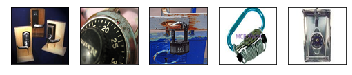

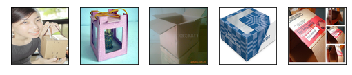

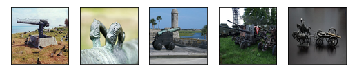

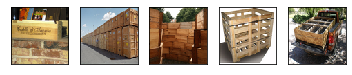

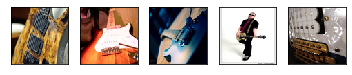

In [6]:
n = 5
k = 5


X_train, X_test, y_train, y_test, tab, dico = build_dataset(X, n, k)#, False, tab, dico)

for i in range(5):
#     plt.figure(i)
#     plt.imshow(X_train[k*i])
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)
    for j in range(5):
        fig.axes[j].get_xaxis().set_visible(False)
        fig.axes[j].get_yaxis().set_visible(False)
    ax1.imshow(X_train[5*i])
    ax2.imshow(X_train[5*i+1])
    ax3.imshow(X_train[5*i+2])    
    ax4.imshow(X_train[5*i+3])
    ax5.imshow(X_train[5*i+4])
    
    

Loading the pre-trained Model and transform it into a feature extraction tool

First test with simple transfer learning and logistic regression

In [9]:
y_test1 = np.zeros(y_test.shape[0])-1

Xt = model.predict(X_train)
# Xt = model.predict(X_train)
print(0)
Xv = model.predict(X_test)
# Xv = model.predict(X_test)
print(1)



clf = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial', max_iter = 1000, penalty='l2')
clf.fit(Xt,y_train)
y_pred = clf.predict(Xv)

print(accuracy_score(y_test, y_pred))

y_learn = np.concatenate([y_train, y_test1])

0
1
0.6033613445378151


In [15]:
# res = load('autoencoder na', 'model')

inputs = res.input
encoded = res.get_layer('activation_17').output
encoded = Flatten()(encoded)
mk2 = Model(inputs=inputs,   outputs=encoded)

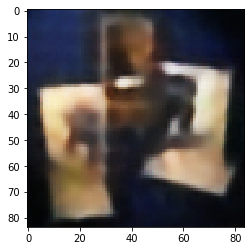

In [23]:
plt.imshow(res.predict(np.array([X_train[0]/255])).reshape((84,84,3)))

In [16]:
Xt1 = mk2.predict(X_train/25)
Xv1 = mk2.predict(X_test)

# clf = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial', max_iter = 1000, penalty='l2')
# clf.fit(Xt,y_train)
# y_pred = clf.predict(Xv)

# print(accuracy_score(y_test, y_pred))

Adding a umap embedding

In [17]:
reducer = umap.UMAP(n_neighbors=12, metric='cosine', n_components=20)

y_test_unsupervised = np.zeros(y_test.shape[0])-1
y_learn = np.concatenate([y_train, y_test_unsupervised])

embedding = reducer.fit(np.concatenate([Xt1, Xv1], axis=0), y_learn)

Xt1 = embedding.transform(Xt1)
Xv1 = embedding.transform(Xv1)

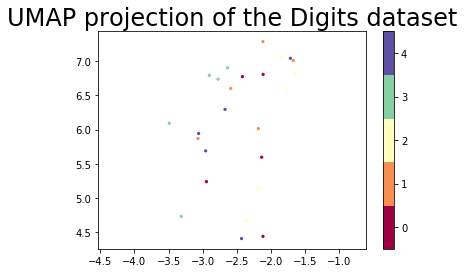

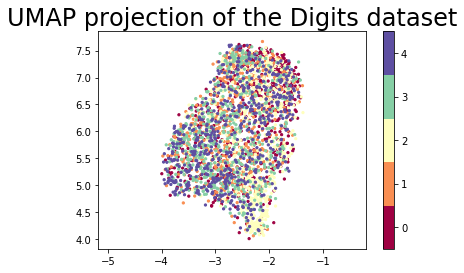

In [18]:

plt.figure(0)
plt.scatter(Xt1[:, 0], Xt1[:, 1], c=y_train, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

plt.figure(1)
plt.scatter(Xv1[:, 0], Xv1[:, 1], c=y_test, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

testing with logistic regression

In [19]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.4)

clf.fit(Xt1,y_train)
y_pseudo = clf.predict(Xv1)

print(accuracy_score(y_test, y_pseudo))

0.2642016806722689


Retraining with pseudo labels on original embedding

In [ ]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.4)
print(0)
clf.fit(np.concatenate([Xt, Xv], axis = 0),np.concatenate([y_train, y_pseudo], axis = 0))
print(1)
y_pred = clf.predict(Xv)
print(2)

print(accuracy_score(y_test, y_pred))

In [ ]:
plt.figure(0)
plt.scatter(Xt1[:, 0], Xt1[:, 1], c=y_train, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

plt.figure(1)
plt.scatter(Xv1[:, 0], Xv1[:, 1], c=y_test, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

plt.figure(2)
plt.scatter(Xv1[:, 0], Xv1[:, 1], c=y_pred, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

In [ ]:
count = 0
c = 0
while count <= 5:
    while c < 100:
        c+=1
        if y_pred[i] != y_test[i]:
            plt.figure(2*i)
            plt.imshow(X_test[i])
            plt.figure(2*i + 1)
            plt.imshow(X_train[5*y_pred[i]])
            count += 1


#### Test with different k in the same n classes

In [ ]:
scores1 = []
scores2 = []
scores3 = []

kshots = [1,3, 5,10,50,100,300,500]

for k in kshots:
    X_train, X_test, y_train, y_test, tab, dico = build_dataset(X, n, k, False, tab, dico)
    
    Xt = model.predict(X_train)
    Xv = model.predict(X_test)
    
    reducer = umap.UMAP(n_neighbors=12, metric='cosine', n_components=20)
    embedding = reducer.fit(np.concatenate([Xt, Xv], axis=0), y_learn)
    
    Xt1 = embedding.transform(Xt)
    Xv1 = embedding.transform(Xv)
    
    y_test1 = np.zeros(y_test.shape[0])-1
    y_learn = np.concatenate([y_train, y_test1])
    
    ## First prediction
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500)
    clf.fit(Xt,y_train)
    
    y_pred = clf.predict(Xv)
    scores1.append(accuracy_score(y_test, y_pred))
    
    print(accuracy_score(y_test, y_pred))
    
    ## Prediction with umap embedding
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500)
    clf.fit(Xt1,y_train)
    
    y_pseudo = clf.predict(Xv1)
    scores2.append(accuracy_score(y_test, y_pseudo))
    
    print(accuracy_score(y_test, y_pseudo))   
    
    ## Final prediction
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500)
    clf.fit(np.concatenate([Xt, Xv], axis = 0),np.concatenate([y_train, y_pseudo], axis = 0))
    
    y_pred = clf.predict(Xv)
    scores3.append(accuracy_score(y_test, y_pred))
    
    print(accuracy_score(y_test, y_pred))
    
    
plt.plot(kshots, scores1)
plt.plot(kshots, scores2)
plt.plot(kshots, scores3)

#### Generic Experiment for validation and averaging of the final score

In [ ]:
scores1 = []
scores2 = []
scores3 = []

n = 5
k = 5

for i in range(100):
    
    X_train, X_test, y_train, y_test, tab, dico = build_dataset(X, n, k)
    print(i)
    ## First prediction for comparison
    Xt = model.predict(X_train)
    Xv = model.predict(X_test)
    

    
#     clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.3)
#     clf.fit(Xt,y_train)
#     y_pred = clf.predict(Xv)
#     print(accuracy_score(y_test, y_pred))
#     a = accuracy_score(y_test, y_pred)
# #     print(a)
#     scores1.append(a)
    
    
    y_test_unsupervised = np.zeros(y_test.shape[0])-1
    y_learn = np.concatenate([y_train, y_test_unsupervised])
    
    ## Prediction with umap embedding
    reducer = umap.UMAP(n_neighbors=15, metric='cosine', n_components=20)
    embedding = reducer.fit(np.concatenate([Xt, Xv], axis=0), y_learn)

    Xt1 = embedding.transform(Xt)
    Xv1 = embedding.transform(Xv)
    
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.3)
    clf.fit(Xt1,y_train)
    y_pseudo = clf.predict(Xv1)
    
    print(accuracy_score(y_test, y_pseudo))
    
    a = accuracy_score(y_test, y_pseudo)
#     print(a)
    scores2.append(a)
    
    ## Final prediction
#     clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.4)
#     clf.fit(np.concatenate([Xt, Xv], axis = 0),np.concatenate([y_train, y_pseudo], axis = 0))

#     y_pred = clf.predict(Xv)
#     accuracy_score(y_test, y_pred)
    
#     a = accuracy_score(y_test, y_pred)
#     print(a)
    
    scores3.append(a)
    print(np.array(scores3).mean())
    
print(np.array(scores1).mean())
print(np.array(scores2).mean())
print(np.array(scores3).mean())

In [ ]:
plt.hist(scores1, bins = 20)

In [ ]:
plt.hist(scores2, bins = 20)

In [ ]:
plt.hist(scores3, bins = 20)

In [ ]:
np.array(scores3).mean()